In [1]:
import torch

    # import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, uninvert, match_scale
from chrislib.data_util import load_image

# import model loading and running the pipeline
from Intrinsic.pipeline import run_pipeline, load_models


intrinsic_model = load_models('v2')

c:\Users\Mahesh Reddy\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


inside load models
inside main if else


Using cache found in C:\Users\Mahesh Reddy/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Mahesh Reddy/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


just above stage 2, stage:  4
yes in stage 2


Using cache found in C:\Users\Mahesh Reddy/.cache\torch\hub\facebookresearch_WSL-Images_main


Col_model
just above stage 3


Using cache found in C:\Users\Mahesh Reddy/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Mahesh Reddy/.cache\torch\hub\facebookresearch_WSL-Images_main


In [2]:
import cv2
from scipy import ndimage

In [3]:
import inspect
import chrislib.general
# Get the file path of the chrislib.general module
path = inspect.getfile(chrislib.general)
print("Path of chrislib.general:", path)

Path of chrislib.general: c:\Users\Mahesh Reddy\anaconda3\envs\dl\lib\site-packages\chrislib\general.py


In [21]:
# intrinsic_model = load_models('paper_weights')

In [4]:
print(torch.cuda.is_available())

True


In [5]:
import numpy as np

In [6]:
inp = load_image('0.png')[:, :, :3]
msk = np.stack((load_image('01'),) * 3, axis=-1)[:, :, :3]
msk_whole = np.ones((256, 256, 3))
tex = load_image('recoloring_textures\yellow_plain_big.jpg')[:, :, :3] ** 2.2

In [7]:
msk.shape

(128, 128, 3, 3)

In [8]:
results = run_pipeline(
    intrinsic_model,
    inp,
    resize_conf=None,
    #maintain_size=True
)

print('results', results.keys())


###for paper weights
# alb = results['albedo']
# image = results['image']
# inv_shd = results['inv_shading']

alb = results['hr_alb']       # High-resolution albedo
image = results['image']      # Original input image
inv_shd = results['gry_shd']  # Inverse shading estimation

shd = uninvert(inv_shd)[:, :, None]

Before run gray pipleine dict_keys(['ord_model', 'iid_model', 'col_model', 'alb_model', 'dif_model'])
inside rungray piple dict_keys(['ord_model', 'iid_model', 'col_model', 'alb_model', 'dif_model'])
After run gray pipline dict_keys(['ord_model', 'iid_model', 'col_model', 'alb_model', 'dif_model'])
Before torch.nograd dict_keys(['ord_model', 'iid_model', 'col_model', 'alb_model', 'dif_model'])
results dict_keys(['ord_full', 'ord_base', 'gry_shd', 'gry_alb', 'image', 'lin_img', 'lr_clr', 'lr_alb', 'lr_shd', 'wb_img', 'hr_alb', 'hr_shd', 'hr_clr', 'dif_shd', 'dif_img', 'residual', 'neg_res', 'pos_res'])


In [26]:
#print(alb.shape)
print('mask shape',msk.shape)
print('shd shape', shd.shape)

mask shape (128, 128, 1)
shd shape (128, 128, 1)


In [25]:
msk_reduced = msk[:, :, 0, 0]  # Shape becomes (128, 128, 1)
msk_reduced = np.expand_dims(msk_reduced, axis=-1)  # Explicitly add the last dimension (128, 128, 1)
msk = msk_reduced

In [27]:

def perform_recolor(msk, alb, shd, shd_power=1.0, recolor=None):
    """
    This function performs illumination-aware recoloring, or applies a shading curve.
    
    Args:
    - msk (numpy array): (HxWx1) denoting the region to perform the edit.
    - alb (numpy array): Linear albedo of the image.
    - shd (numpy array): Linear shading of the image.
    - shd_power (float): Exponent to apply to the shading (<1 for more diffuse, >1 for more specular).
    - recolor (numpy array): A texture to apply to the edited region, no recoloring is performed if set to None.
    
    Returns:
    - recolored (numpy array): Recolored image with gamma correction.
    """

    
    if recolor is None:
        our_new_alb = alb
    else:
        # Match the scale of the texture to the albedo in the edited region
        recolor = match_scale(recolor, alb, msk.astype(bool))
        our_new_alb = ((1.0 - msk) * alb) + (msk * recolor)

    # Expand msk to match the shape of shd
    if msk.shape[-1] == 1:
        msk_expanded = np.repeat(msk, shd.shape[-1], axis=-1)
    else:
        msk_expanded = msk

    # Apply exponentiation to the shading of the region
    masked_shd = msk_expanded * (shd ** shd_power)
    new_shd = ((1.0 - msk_expanded) * shd) + masked_shd

    # Combine edited albedo and shading, apply gamma correction, and clip
    recolored = (our_new_alb * new_shd) ** (1 / 2.2)

    return recolored.clip(0, 1)


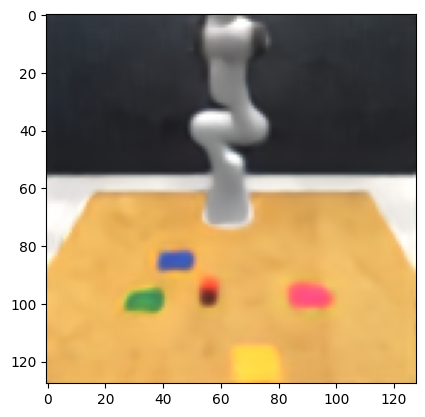

In [31]:

# Perform recoloring and find corners
recolored_image = perform_recolor(msk, alb, shd)

import matplotlib.pyplot as plt
# Visualize
plt.figure(0)
plt.imshow(recolored_image)


Text(0.5, 1.0, 'shading')

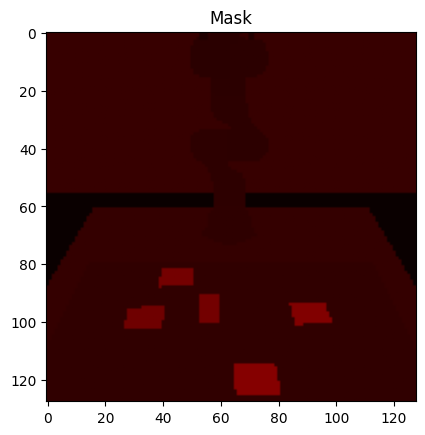

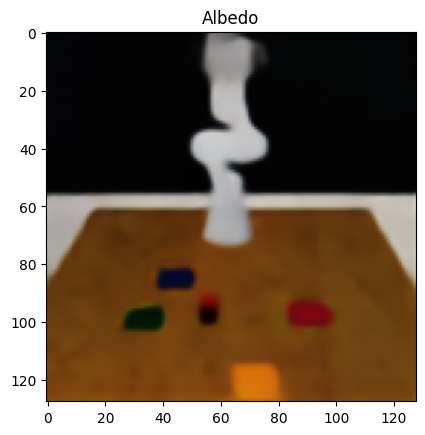

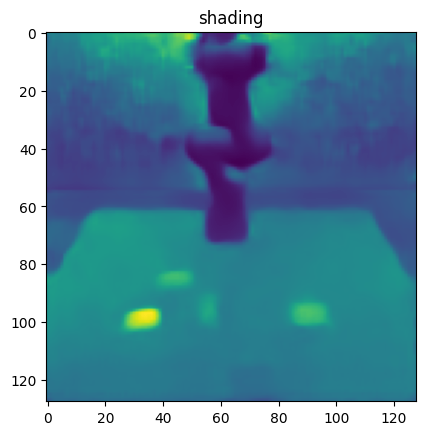

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(0)
plt.imshow(msk[:, :, :, 0])  # Assuming you want to take the first channel
plt.title("Mask")
plt.figure(1)
plt.imshow(alb)
plt.title("Albedo")
plt.figure(2)
plt.imshow(shd)
plt.title("shading")
# plt.figure(3)
# plt.imshow(tex)
# plt.figure(4)
# plt.imshow(msk_whole)

In [ ]:
# NOTE: setting the shading exponent to >1 will make the shading appear more specular,
# but small errors in the shading (albedo leakage) will be amplified in some cases
recolored_img = perform_recolor(msk, alb, shd, 1.0, recolor=tex[:256, :256, :])
show(recolored_img)

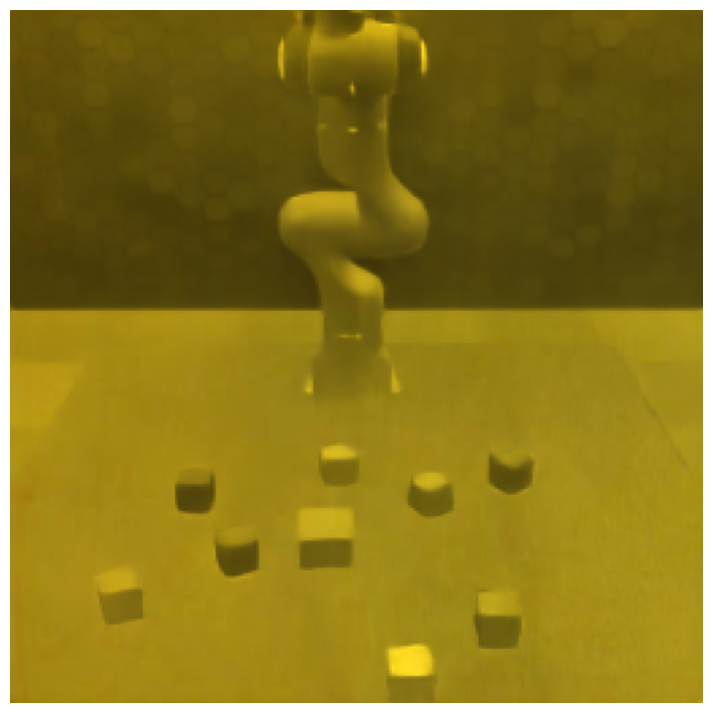

In [24]:
'''
Single color recoloring
'''
whole_recolored_img = perform_recolor(msk_whole, alb, shd, 1.0, recolor=tex[:256, :256, :])
show(whole_recolored_img)

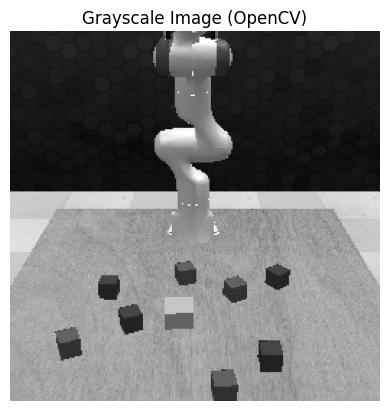

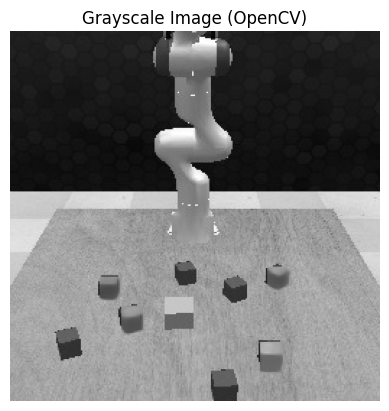

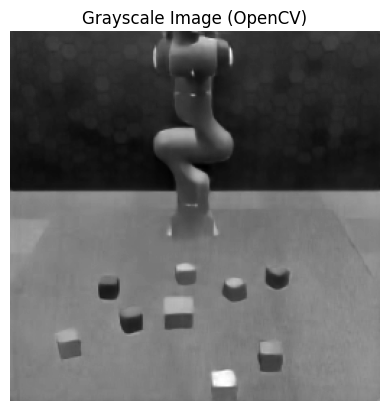

In [25]:
import cv2

# Convert the image to grayscale using OpenCV
gray_image_cv2 = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

gray_recolored_img_cv2 = cv2.cvtColor((recolored_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

gray_whole_recolored_img_cv2 = cv2.cvtColor((whole_recolored_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Display the grayscale image
plt.figure(6)
plt.imshow(gray_image_cv2, cmap='gray')
plt.title('Grayscale Image (OpenCV)')
plt.axis('off')
plt.show()

# Display the grayscale image
plt.figure(7)
plt.imshow(gray_recolored_img_cv2, cmap='gray')
plt.title('Grayscale Image (OpenCV)')
plt.axis('off')
plt.show()

# Display the grayscale image
plt.figure(8)
plt.imshow(gray_whole_recolored_img_cv2, cmap='gray')
plt.title('Grayscale Image (OpenCV)')
plt.axis('off')
plt.show()